# PyTorch: Learning loop
What is the connection between `loss.backward()` and `optimizer.step()`?

Inspired by this [post on stackoverflow](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step).

In [1]:
import torch
import math

torch.__version__

/home/arash/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.12.0+cu102'

- `torch.Tensor` is the basic datatype in PyTorch. 
- Can be used to store scalars, vectors, matrices, or higher order tensors. 
- Is a Python class.
- Often used as an optimization variable.
- It can store a gradient of some loss w.r.t. itself.

In [2]:
w = torch.tensor([1, 2, math.pi/3], requires_grad=True)
w

tensor([1.0000, 2.0000, 1.0472], requires_grad=True)

In [3]:
loss = 5*w[0] + w[1]**3 + torch.sin(w[2])
loss

tensor(13.8660, grad_fn=<AddBackward0>)

The loss is 
$$\ell(w) = 5w_0 + w_1^3 + \sin(w_2).$$
where $w = (w_0, w_1, w_2)$.
The gradient of the loss w.r.t. $w$ is
$$
\nabla \ell(w) = 
\begin{bmatrix}
5 \\ 3 w_1^2 \\ \cos(w_2)
\end{bmatrix}.
$$

In [4]:
print(w.grad)
loss.backward() # This updates w.grad, does nothing to the loss itself.
print(w.grad)

None
tensor([ 5.0000, 12.0000,  0.5000])


In [5]:
optim = torch.optim.SGD([w], lr=0.1)

In [6]:
w, -0.1*w.grad, w-0.1*w.grad

(tensor([1.0000, 2.0000, 1.0472], requires_grad=True),
 tensor([-0.5000, -1.2000, -0.0500]),
 tensor([0.5000, 0.8000, 0.9972], grad_fn=<SubBackward0>))

In [7]:
print(' Init:', w, f'| loss = {loss.item():2.2f}'), #print("grad =", w.grad)
for i in range(3):
    optim.step()  # just updates w to w - lr*w.grad
    print(f'i = {i+1}:', w, f'| loss = {loss.item():2.2f}'), #print("grad =", w.grad)

 Init: tensor([1.0000, 2.0000, 1.0472], requires_grad=True) | loss = 13.87
i = 1: tensor([0.5000, 0.8000, 0.9972], requires_grad=True) | loss = 13.87
i = 2: tensor([-7.4506e-09, -4.0000e-01,  9.4720e-01], requires_grad=True) | loss = 13.87
i = 3: tensor([-0.5000, -1.6000,  0.8972], requires_grad=True) | loss = 13.87


---
Let $\mu =$ `lr` $= 0.1$ be the learning rate. What the above does is
$$
w^{(i+1)} = w^{(i)} - \mu \nabla \ell(w^{(0)}), \quad i = 0,1,2
$$
where $w^{(0)} = w$.

In [8]:
def compute_loss(u):                           # u is a vector of length 3
    return 5*u[0] + u[1]**3 + torch.sin(u[2])

w = torch.tensor([1., 2, math.pi/3], requires_grad=True)
loss = compute_loss(w)

print(w.grad)
loss.backward() # loss.backward still updates w.grad
print(w.grad)


None
tensor([ 5.0000, 12.0000,  0.5000])


In [9]:
w = torch.tensor([1., 2, math.pi/3], requires_grad=True)
optim = torch.optim.SGD([w], lr=.1)  

for i in range(3):
    loss = compute_loss(w)
    loss.backward()  # Changes w.grad
    print('grad = ', w.grad)
    optim.step() # Changes w
    print('PARA = ', w)

grad =  tensor([ 5.0000, 12.0000,  0.5000])
PARA =  tensor([0.5000, 0.8000, 0.9972], requires_grad=True)
grad =  tensor([10.0000, 13.9200,  1.0427])
PARA =  tensor([-0.5000, -0.5920,  0.8929], requires_grad=True)
grad =  tensor([15.0000, 14.9714,  1.6698])
PARA =  tensor([-2.0000, -2.0891,  0.7260], requires_grad=True)


Mathamtically, the above does this:
$$
w^{(i+1)} = w^{(i)} - \mu \sum_{k=0}^i \nabla \ell(w^{(k)}), \quad i = 0,1,2
$$
which is not the gradient descent.

In [10]:
def compute_loss(u):                           # u is a vector of length 3
    return 5*u[0] + u[1]**3 + torch.sin(u[2])
    
w = torch.tensor([1., 2, math.pi/3], requires_grad=True)
optim = torch.optim.SGD([w], lr=.1)

for i in range(3):
    optim.zero_grad()
    loss = compute_loss(w)
    loss.backward()
    print('grad = ', w.grad)
    optim.step()
    print('PARA = ', w)

grad =  tensor([ 5.0000, 12.0000,  0.5000])
PARA =  tensor([0.5000, 0.8000, 0.9972], requires_grad=True)
grad =  tensor([5.0000, 1.9200, 0.5427])
PARA =  tensor([-7.4506e-09,  6.0800e-01,  9.4293e-01], requires_grad=True)
grad =  tensor([5.0000, 1.1090, 0.5874])
PARA =  tensor([-0.5000,  0.4971,  0.8842], requires_grad=True)


Mathamtically, the above does the correct gradient descent:
$$
w^{(i+1)} = w^{(i)} - \mu \nabla \ell(w^{(i)}), \quad i = 0,1,2
$$

---
Let's check correctness, by implementing our own gradient descent. The gradient of the loss w.r.t. $w$ is
$$
\nabla \ell(w) = 
\begin{bmatrix}
5 \\ 3 w_1^2 \\ \cos(w_2)
\end{bmatrix}
$$

In [11]:
def compute_grad(u):
    return torch.tensor([5, 3*u[1]**2, torch.cos(u[2])])
    
w = torch.tensor([1., 2, math.pi/3], requires_grad=True)
for i in range(3):
    grad = compute_grad(w)
    print('grad = ', grad)
    w = w - 0.1*grad
    print('PARA = ', w)

grad =  tensor([ 5.0000, 12.0000,  0.5000])
PARA =  tensor([0.5000, 0.8000, 0.9972], grad_fn=<SubBackward0>)
grad =  tensor([5.0000, 1.9200, 0.5427])
PARA =  tensor([0.0000, 0.6080, 0.9429], grad_fn=<SubBackward0>)
grad =  tensor([5.0000, 1.1090, 0.5874])
PARA =  tensor([-0.5000,  0.4971,  0.8842], grad_fn=<SubBackward0>)


# A more interesting example
Consider minimizing the following bivariate function:
$$
\ell(w) = w_0^2 + 2w_1^2 \cdot |\cos(2\pi w_0)|
$$
where $w = (w_0,w_1)$.

In [12]:
import numpy as np

def compute_loss(w):
    return w[0]**2 + 2*w[1]**2*torch.abs(torch.cos(2*math.pi*w[0]))

w = torch.tensor([-2., 2], requires_grad=True)
optim = torch.optim.SGD([w], lr=.01)

niter = 400
traj = torch.zeros(3,niter)
for i in range(niter):
    optim.zero_grad()
    loss = compute_loss(w)    
    traj[:2,i] = w
    traj[2,i] = loss
    loss.backward()
    optim.step()

traj = traj.detach().numpy()

# traj[0] = w[0]
# traj[1] = w[1]
# traj[2] = loss

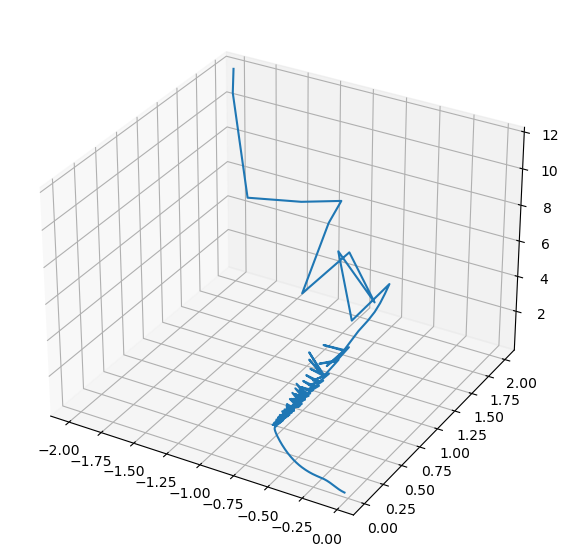

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.plot3D(traj[0,:],traj[1,:],traj[2,:]);

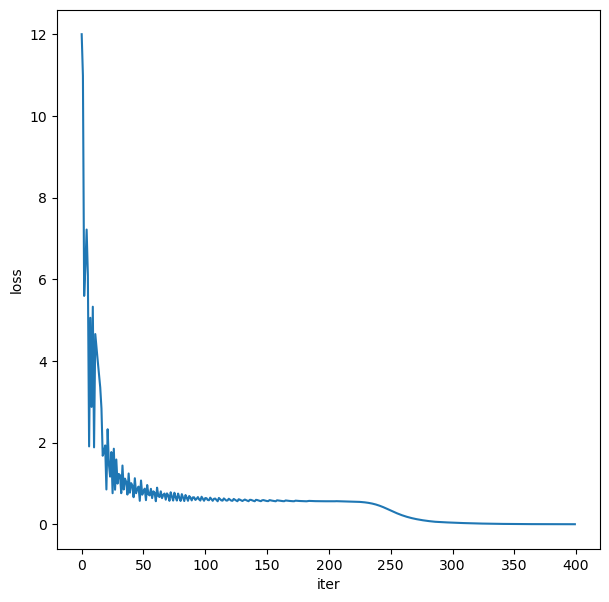

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.plot(range(niter), traj[2,:]), plt.xlabel('iter'), plt.ylabel('loss');
# ax.plot(traj[0,:], traj[1,:]), plt.xlabel('w0'), plt.ylabel('w1');
# ax.semilogx(range(niter), traj[2,:])

# Multiple trajectories
Consider the so called Himmelblau's function which among the common [test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization):
$$
 \ell(w) = (w_0^2 + w_1 -11)^2 + (w_0 + w_1^2 - 7)^2
$$
where $w = (w_0, w_1)$.

In [15]:
import numpy as np
def compute_loss(w):
    return (w[0]**2+w[1]-11)**2 + (w[0]+w[1]**2-7)**2

def gd(niter = 100):
    # w = 2*torch.rand(2, requires_grad=True)-1.5
    w = 2*torch.rand(2)-1.5 # U[-1.5, 0.5]^2
    w.requires_grad_()
    optim = torch.optim.SGD([w], lr=.005)
    traj = torch.zeros(3,niter)
    for i in range(niter):
        optim.zero_grad()
        loss = compute_loss(w)    
        traj[:2,i] = w
        traj[2,i] = loss
        loss.backward()
        optim.step()
        
    return traj.detach().numpy()

niter = 200
ntraj = 50
multi_traj = np.zeros((3,niter,ntraj))
for t in range(ntraj):        
    multi_traj[:,:,t] = gd(niter)

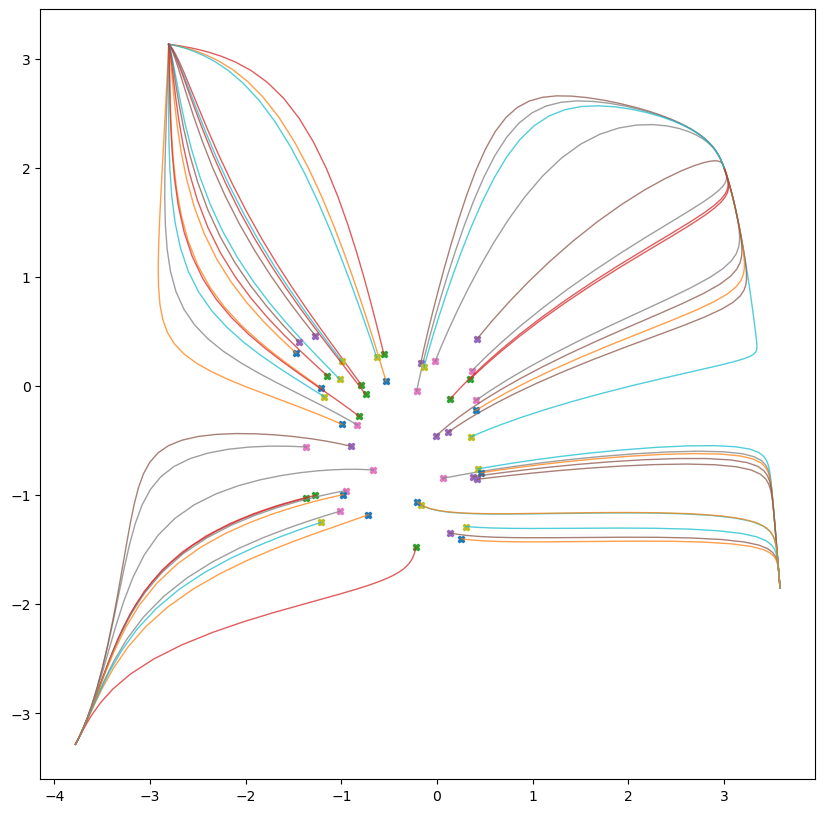

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# fig = plt.figure(figsize=(7,7))
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

traj_idx = np.arange(ntraj)/ntraj
for t in range(ntraj):        
    # ax.plot3D(X[0,:,t],X[1,:,t],X[2,:,t],linewidth=1)
    ax.plot(multi_traj[0,0,t], multi_traj[1,0,t], marker="X", markersize=5)
    ax.plot(multi_traj[0,:,t], multi_traj[1,:,t], alpha=.75, linewidth=1)
plt.show()

In [17]:
def print_state(w):
    print(f"is_leaf = {w.is_leaf}, requires_grad = {w.requires_grad}")

# w = 2*torch.rand(2, requires_grad=True)-1
w = 2*torch.rand(2)-1
print_state(w)
w.requires_grad_()
print_state(w)
loss = compute_loss(w)
loss.backward()
optim = torch.optim.SGD([w], lr=.005)
# optim.step()

is_leaf = True, requires_grad = False
is_leaf = True, requires_grad = True


In [18]:
w = 2*torch.rand(2, requires_grad=True)-1  # A tensor not created by the user but by an operation, hence is_leaf is False
print_state(w)

is_leaf = False, requires_grad = True


https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html

All Tensors that have `requires_grad` which is `False` will be leaf Tensors by convention.

For Tensors that have `requires_grad` which is `True`, they will be leaf Tensors if they were created by the user. This means that they are not the result of an operation and so grad_fn is None.

Only leaf Tensors will have their grad populated during a call to `backward()`. To get grad populated for non-leaf Tensors, you can use `retain_grad()`.